In [1]:
import cv2
import os, shutil, time
from google.colab.patches import cv2_imshow

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

from skimage import color
from skimage import io 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.models as models 
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import torchvision.transforms.functional
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path


In [3]:
from google.colab import drive 
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Convert Lab to Rgb Helper functions
def normalize(tensor_unnormalized):
  """Normalizes batch of images, expect tensor input"""
  norm_ten = torch.div(tensor_unnormalized, 255)
  return norm_ten

def unnormalize(tensor_normalized):
  """Unnormalizes batch of images, expect tensor input"""
  unnorm_ten = torch.multiply(tensor_normalized, 255)
  return unnorm_ten

def lab_to_rgb_cv2(gray_im, ab_im):
  """Accepts unnormalized values"""
  #print(ab_im.min(), ab_im.max())

  lab_im = np.zeros((224,224,3), dtype="uint8")
  lab_im[:,:,0] = gray_im
  lab_im[:,:,1] = ab_im[:,:,0]
  lab_im[:,:,2] = ab_im[:,:,1]
  lab_im = lab_im.astype('uint8')
  rgb_image = cv2.cvtColor(lab_im, cv2.COLOR_Lab2RGB)
  return rgb_image

In [5]:
#Create a custom dataset class 
class CustomDataset(Dataset):
  def __init__(self):
    #Load the data from google drive
    gray_images = np.load('/content/drive/MyDrive/archive/l/gray_scale.npy')
    ab_1_colors = np.load('/content/drive/MyDrive/archive/ab/ab/ab1.npy')
    ab_2_colors = np.load('/content/drive/MyDrive/archive/ab/ab/ab2.npy')
    ab_3_colors = np.load('/content/drive/MyDrive/archive/ab/ab/ab3.npy')
    
    #convert data to tensor format
    ab_colors = np.vstack((ab_1_colors, ab_2_colors, ab_3_colors))
    #get 1000 first images
    self.gray_images = gray_images[:1000,:,:]
    self.ab_colors = ab_colors[:1000,:,:]

    #transforms numpy array of (H x W x C) to Tensor (C x H x W)
    self.transforms = transforms.Compose([transforms.ToTensor()])
    #check what to tensor does 
  
  def __len__(self):
    """Get length of the input tensor"""
    return len(self.gray_images)
  def __getitem__(self, idx):
    '''Get a single item of gray and ab image'''
    image_gray = self.gray_images[idx]
    image_ab = self.ab_colors[idx]

    #need to expand gray dimensions since it is a [224, 224] tensor 
    image_gray = np.expand_dims(image_gray, axis=2)

    #transform to 0-1 float values:
    image_gray = self.transforms(image_gray)
    image_ab = self.transforms(image_ab)

    return image_gray.cuda(), image_ab.cuda()
#Create an instance of a dataset class
dataset = CustomDataset()

In [6]:
class ColorizationAttempt1(nn.Module):
  def __init__(self):
    super(ColorizationAttempt1, self).__init__()

    #use resnet18 as encoder layer.
    #resnet18 expects an image of (3,H,W) normalized to be [0,1]
    resnet = models.resnet18(num_classes=365)

    #Change first conv layer to accept single channel input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    #extract midlevel features 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    #Need to freeze the gradients on a resnet model
    for param in self.parameters():
      param.requires_grad = False

    #Variables for a resnet Basic Block architecture.
    self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride = 1, padding = 1, bias=False)
    self.bn = nn.BatchNorm2d(128)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, bias = False)
    

    self.upsample = nn.Sequential(
        nn.PixelShuffle(4),
        nn.Conv2d(8,8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.PixelShuffle(2),
        nn.Conv2d(2,2, kernel_size = 3, stride=1, padding=1),
        nn.ReLU()
    )

  def forward(self, input):
    #Encoder layer downsampling
    midlevel_features = self.midlevel_resnet(input)

    #Basic resnet Block no dimensional change
    #Add more convolutional layers for improved results
    #Block1
    output = self.conv1(midlevel_features)
    output = self.bn(output)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.bn(output)

    #Upsample
    output = self.upsample(midlevel_features)
    return output

In [7]:
#Defining hyperparameters
model = ColorizationAttempt1()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 0.0)

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

#Train and validation loader functions
train, val = torch.utils.data.random_split(dataset, [800,200], generator = torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size= 128, shuffle=True)

In [69]:
 model

ColorizationAttempt1(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Epoch: 0
Running loss: 0.129
Loss:0.129
(224, 224, 3)


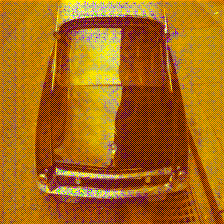

Epoch: 25
Running loss: 0.124
Loss:0.124
(224, 224, 3)


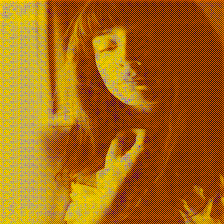

Epoch: 50
Running loss: 0.101
Loss:0.101
(224, 224, 3)


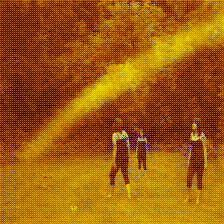

Epoch: 75
Running loss: 0.0356
Loss:0.0356
(224, 224, 3)


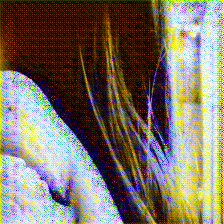

Epoch: 100
Running loss: 0.0253
Loss:0.0253
(224, 224, 3)


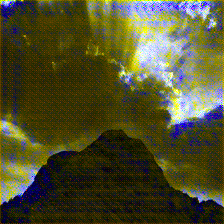

Epoch: 125
Running loss: 0.0195
Loss:0.0195
(224, 224, 3)


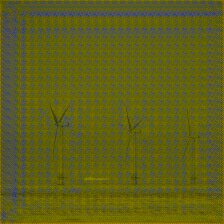

Epoch: 150
Running loss: 0.0178
Loss:0.0178
(224, 224, 3)


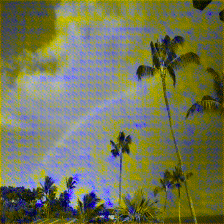

Epoch: 175
Running loss: 0.0148
Loss:0.0148
(224, 224, 3)


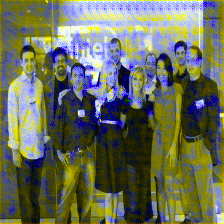

Epoch: 200
Running loss: 0.0123
Loss:0.0123
(224, 224, 3)


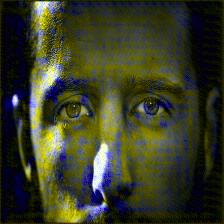

Epoch: 225
Running loss: 0.0125
Loss:0.0125
(224, 224, 3)


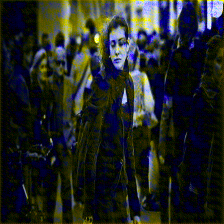

Epoch: 250
Running loss: 0.0116
Loss:0.0116
(224, 224, 3)


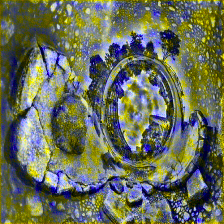

Epoch: 275
Running loss: 0.00981
Loss:0.00981
(224, 224, 3)


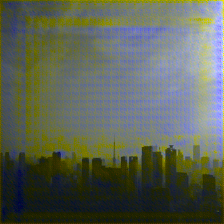

Epoch: 300
Running loss: 0.00951
Loss:0.00951
(224, 224, 3)


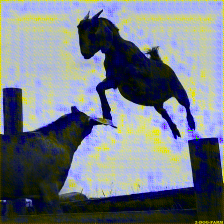

Epoch: 325
Running loss: 0.00979
Loss:0.00979
(224, 224, 3)


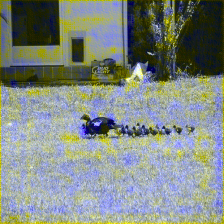

Epoch: 350
Running loss: 0.00804
Loss:0.00804
(224, 224, 3)


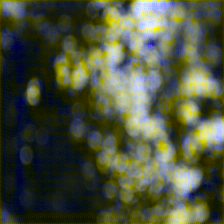

Epoch: 375
Running loss: 0.00722
Loss:0.00722
(224, 224, 3)


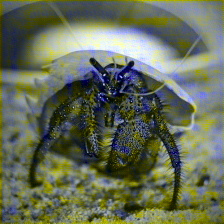

Epoch: 400
Running loss: 0.00659
Loss:0.00659
(224, 224, 3)


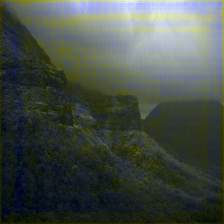

Epoch: 425
Running loss: 0.00652
Loss:0.00652
(224, 224, 3)


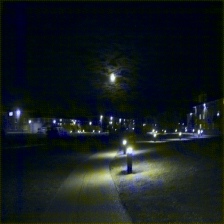

Epoch: 450
Running loss: 0.00711
Loss:0.00711
(224, 224, 3)


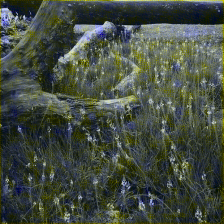

Epoch: 475
Running loss: 0.00605
Loss:0.00605
(224, 224, 3)


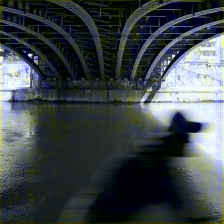

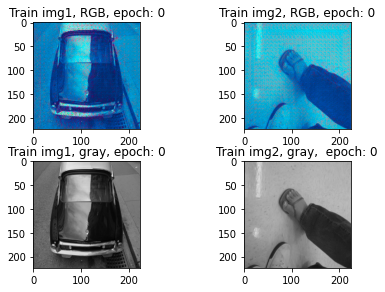

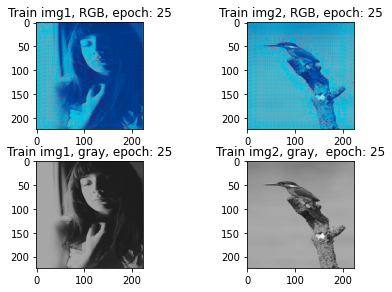

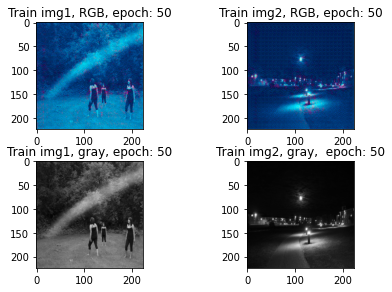

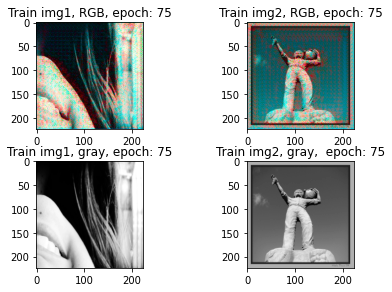

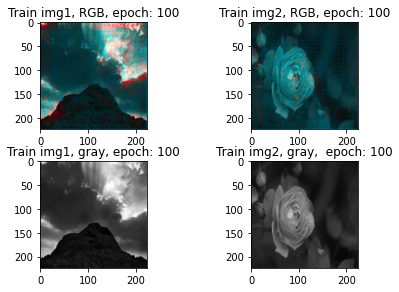

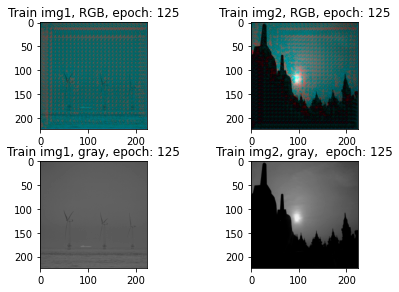

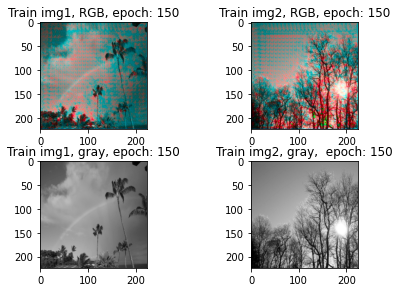

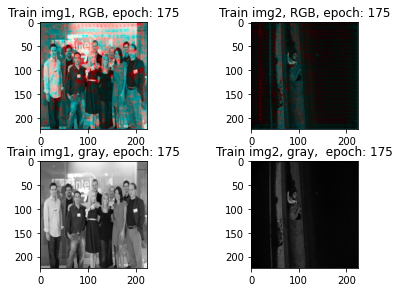

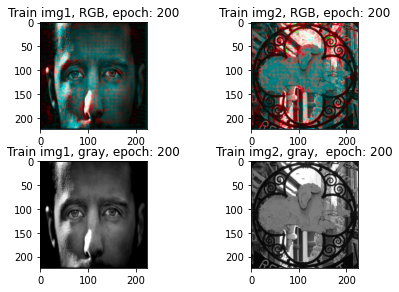

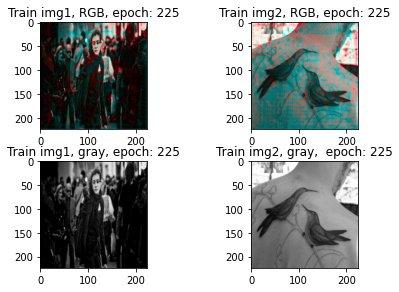

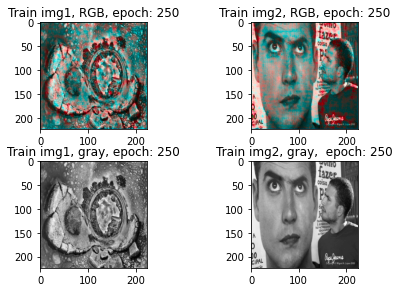

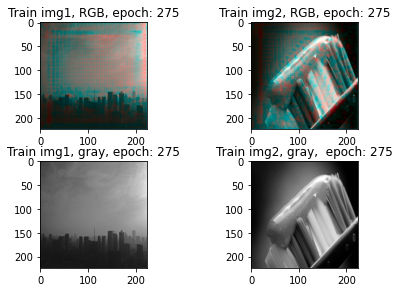

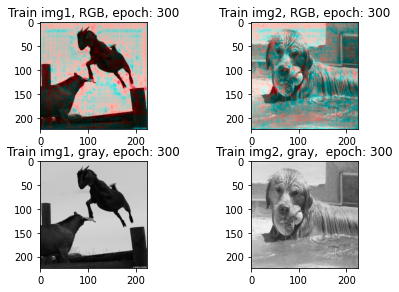

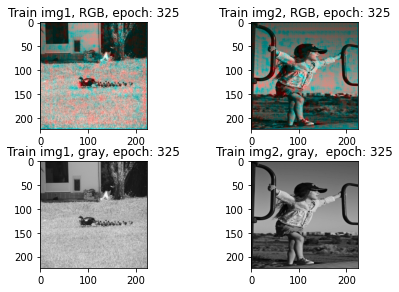

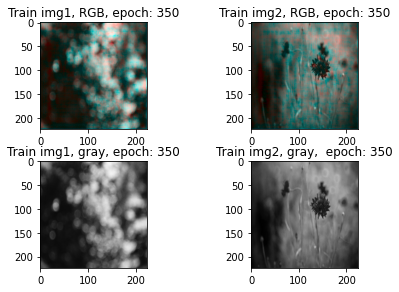

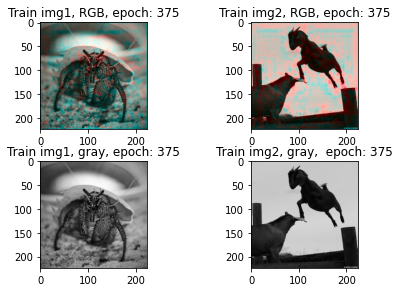

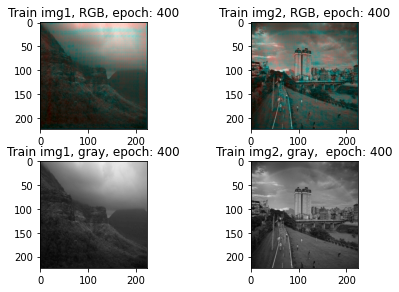

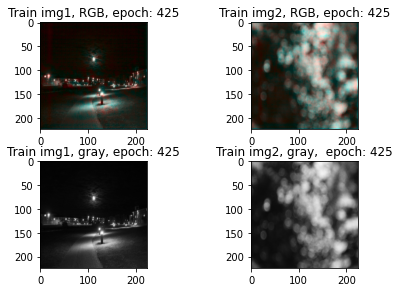

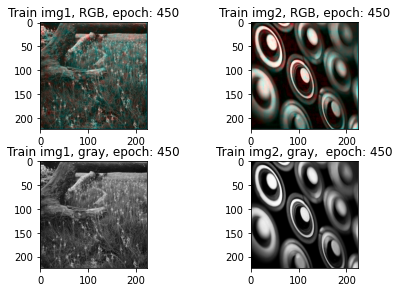

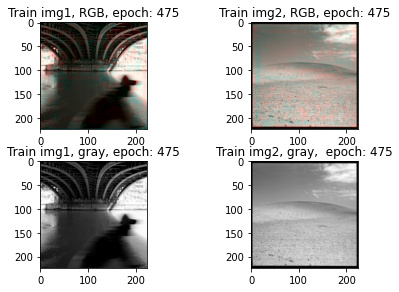

In [10]:
"""Training Loop"""
epochs = 500
vis_images = {}
img_list = []
loss_list = []
for epoch in range(epochs):
  running_loss = 0
  for i, (gray_image, ab_image) in enumerate(train_loader, 0):
    #zero the optimizer gradient
    optimizer.zero_grad()

    #forward + backward + optimize
    
    out_ab_images = model(gray_image)
    loss = criterion(out_ab_images, ab_image)

    #print(ab_image.shape,out_ab_images.shape, ab_image.min(), ab_image.max(), out_ab_images.min(), out_ab_images.max())
    #compute loss 
    loss.backward()
    running_loss += loss
    #run optimizer
    optimizer.step()
    loss_list.append(loss.item())

    #stats 
    if epoch % 25 == 0 and i == 0:
      print(f"Epoch: {epoch}")
      print(f"Running loss: {running_loss:.3}")
      print(f"Loss:{loss:.3}")
      
      torch.save(model, "/content/drive/MyDrive/archive/model1_12_5_21.pt")
      
      #unnormalize images before showing them 
      gray_unnormed = unnormalize(gray_image)
      ab_unnormed = unnormalize(out_ab_images)

      #Images in a batch
      rgb_images = [np.transpose(lab_to_rgb_cv2(gray.squeeze().cpu().detach().numpy(), ab.permute(1,2,0).cpu().detach().numpy()), axes=(2,1,0)) for gray, ab in zip(gray_image, out_ab_images)]
      
      #single image
      rgb = lab_to_rgb_cv2(gray_unnormed[0].squeeze().cpu().detach().numpy(), ab_unnormed[0].permute(1,2,0).cpu().detach().numpy())
      rgb2 = lab_to_rgb_cv2(gray_unnormed[1].squeeze().cpu().detach().numpy(), ab_unnormed[1].permute(1,2,0).cpu().detach().numpy())
      rgb_real = lab_to_rgb_cv2(gray_unnormed[0].squeeze().cpu().detach().numpy(), dataset.ab_colors[0])

      print(rgb.shape)
      #Plot a couple of images 
      figure, axis = plt.subplots(2,2)
      figure.tight_layout()
      axis[0,0].imshow(rgb)
      axis[0,0].set_title(f'Train img1, RGB, epoch: {epoch}')
      axis[0,1].imshow(rgb2)
      axis[0,1].set_title(f'Train img2, RGB, epoch: {epoch}')
      axis[1,0].imshow(gray_unnormed[0].squeeze().cpu().detach().numpy(), cmap = 'gray', vmin=0, vmax=255)
      axis[1,0].set_title(f'Train img1, gray, epoch: {epoch}')
      axis[1,1].imshow(gray_unnormed[1].squeeze().cpu().detach().numpy(), cmap = 'gray', vmin=0, vmax=255)
      axis[1,1].set_title(f'Train img2, gray,  epoch: {epoch}')
      #plt.imshow(torchvision.utils.make_grid(rgb_images))
      cv2_imshow(rgb)
      vis_images[epoch] = rgb
      img_list.append(rgb)

      #figure,axis = plt.subplots(1,2,figsize)



Text(0.5, 0, 'Epoch')

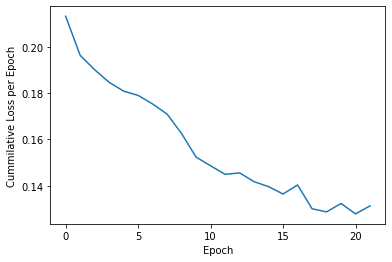

In [9]:
#Plot the loss function per epoch
#Take the average loss of a single batch for each epoch and plot against # of epochs
new_list = loss_list[::32]
plt.plot(new_list)
plt.ylabel('Cummilative Loss per Epoch')
plt.xlabel('Epoch')

Loss for image 0 is 0.00435617845505476
0
Loss for image 1 is 0.00407836539670825
1
Loss for image 2 is 0.004134990740567446
3
Loss for image 3 is 0.0038414164446294308
6
Loss for image 4 is 0.004631565883755684
10
Loss for image 5 is 0.004193300846964121
15
Loss for image 6 is 0.0043602315708994865
21
Loss for image 7 is 0.004489018116146326
28
Average Loss : 0.0012173239374533296


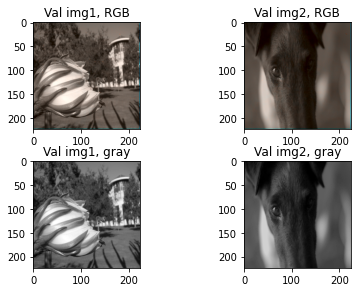

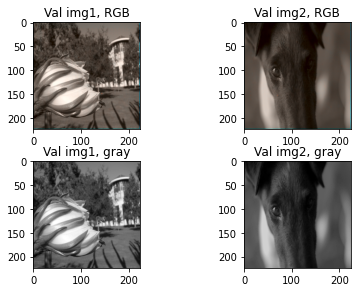

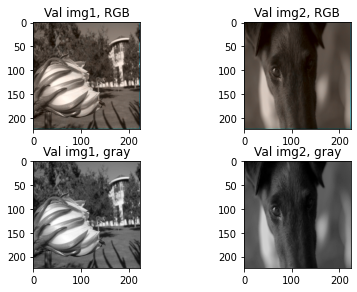

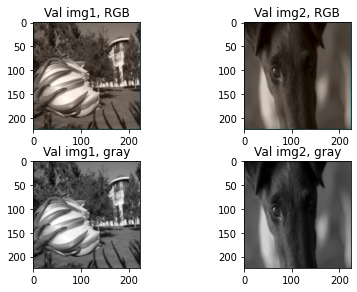

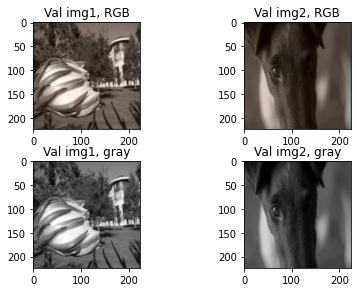

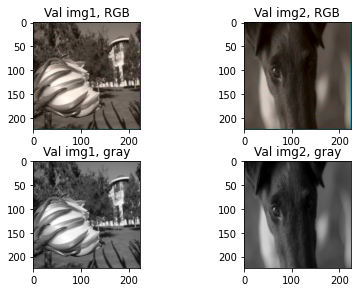

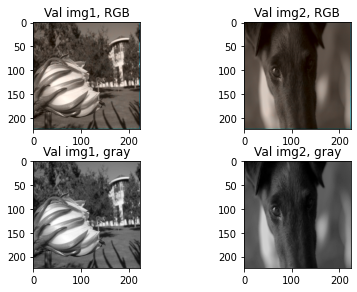

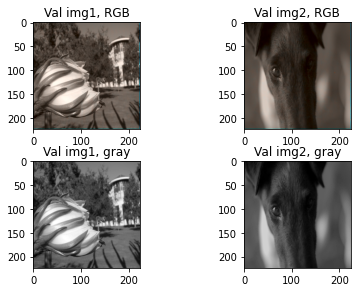

In [11]:
"""Validation"""

val_imgs = []
val_losses = []
with torch.no_grad():
  total_loss = 0
  iter = 0
  for i, (gray_image_val, ab_image_val) in enumerate(val_loader, 0):
    
    out_ab_image = model(gray_image_val)
    loss = criterion(out_ab_image, ab_image_val)

    total_loss += loss
    iter += i
    print(f"Loss for image {i} is {loss}")

    val_losses.append(loss)

    #Display the image
    #normalize the values before displaying the image
    gray_val_unnorm = unnormalize(gray_image)
    ab_val_unnorm = unnormalize(out_ab_image)

    #convert to rgb
    rgb = lab_to_rgb_cv2(gray_val_unnorm[0].squeeze().cpu().detach().numpy(), ab_val_unnorm[0].permute(1,2,0).cpu().detach().numpy())
    rgb2 = lab_to_rgb_cv2(gray_val_unnorm[1].squeeze().cpu().detach().numpy(), ab_val_unnorm[1].permute(1,2,0).cpu().detach().numpy())
    
    #Show 2 images in gray and rgb
    print(iter)
    figure, axis = plt.subplots(2,2)
    figure.tight_layout()
    axis[0,0].imshow(rgb)
    axis[0,0].set_title('Val img1, RGB')
    axis[0,1].imshow(rgb2)
    axis[0,1].set_title('Val img2, RGB')
    axis[1,0].imshow(gray_val_unnorm[0].squeeze().cpu().detach().numpy(), cmap = 'gray', vmin=0, vmax=255)
    axis[1,0].set_title('Val img1, gray')
    axis[1,1].imshow(gray_val_unnorm[1].squeeze().cpu().detach().numpy(), cmap = 'gray', vmin=0, vmax=255)
    axis[1,1].set_title('Val img2, gray')

  average_loss = total_loss/iter
  print(f"Average Loss : {average_loss}")